In [1]:
import os
# from collections import Counter
# from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
from torchvision.ops import deform_conv2d
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU instead.")

Using GPU: NVIDIA GeForce RTX 2070 SUPER


In [3]:
NUM_EPOCHS = 20
BATCH_SIZE = 32

## Data Processing

In [4]:
label_map = {'notumor': 0, 'glioma': 1, 'meningioma': 2, 'pituitary': 3}

def load_images(base_path):
    images = []
    labels = []
    
    for label in label_map.keys():
        path = os.path.join(base_path, label)
        for file in tqdm(os.listdir(path)):
            file_path = os.path.join(path, file)

            # process image
            image = Image.open(file_path).convert('L')
            # image = image_to_tensor(image)
            images.append(image)
            
            # (binary label, multiclass label)
            labels.append((label_map[label]))
    
    return images, labels

all_images, all_labels = load_images('./preprocessed_data/')

x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=0.2, random_state=69)

y_train = [int(label != 0) for label in y_train]
y_test =  [int(label != 0) for label in y_test]

100%|██████████| 1740/1740 [00:00<00:00, 3972.54it/s]


In [5]:
from torch.utils.data import Dataset

# I don't want to deal with the ImageFolder loader
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
    
# from https://github.com/pytorch/vision/issues/6192
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.05
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

# Testing transform
simple_transform = transforms.Compose([
    transforms.Normalize((0.5,), (0.5,))
])

# Training Transforms
base_transform = transforms.Compose([
    gauss_noise_tensor,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.5,), (0.5,))
])
rotate_transform = transforms.Compose([
    gauss_noise_tensor,
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(180),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
# process training sets (no data augment and data augment)
image_to_tensor = transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)])

base_image_train = [image_to_tensor(image.copy()) for image in x_train]
rotate_image_train = [image_to_tensor(image.copy()) for image in x_train]

base_train_loader = DataLoader(CustomDataset(base_image_train, y_train, base_transform), 
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                drop_last=True, # so that RIC can work properly
                                pin_memory=True,
                                num_workers=3)
rotated_train_loader = DataLoader(CustomDataset(rotate_image_train, y_train, rotate_transform), 
                                batch_size=BATCH_SIZE,
                                shuffle=True,
                                drop_last=True, # so that RIC can work properly
                                pin_memory=True,
                                num_workers=3)

# produce test images at fixed rotations
test_loader_per_rotation = dict()
for angle in range(0, 360, 30):
    test_images = []
    test_labels = []
    for image, label in zip(x_test, y_test):
        rotated_image = image.copy()
        rotated_image = rotated_image.rotate(angle)
        rotated_image = image_to_tensor(rotated_image)

        test_images.append(rotated_image)
        test_labels.append(label)

    test_loader_per_rotation[angle] = DataLoader(
                                        CustomDataset(test_images, test_labels, simple_transform), 
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        drop_last=True, # so that RIC can work properly
                                        pin_memory=True,
                                        num_workers=3)
    

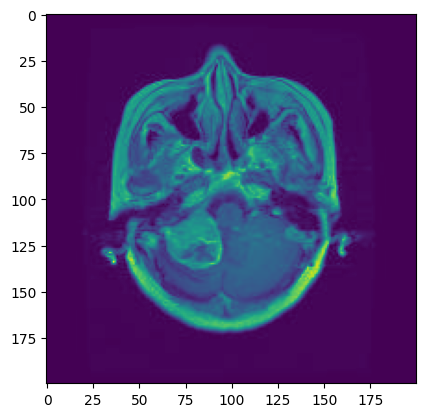

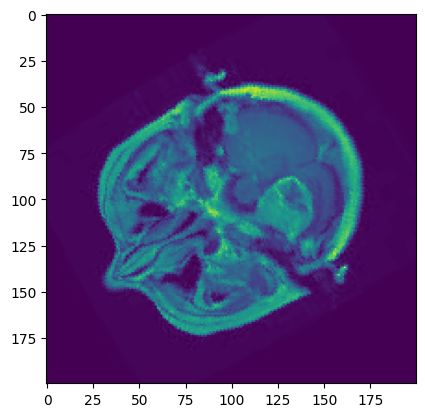

In [7]:
im0, _ = test_loader_per_rotation[0].dataset[0]
plt.imshow(im0.permute(1, 2, 0))
plt.show()
im60, _ = test_loader_per_rotation[120].dataset[0]
plt.imshow(im60.permute(1, 2, 0))
plt.show()

## Model Definition

In [8]:
class StandardCNN(nn.Module):
    def __init__(self):
        super(StandardCNN, self).__init__()
        # 200x200 pixel grayscale image
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1) 
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(p=0.2)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(p=0.2)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(64 * 25 * 25, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)  # No activation, raw logits for CrossEntropyLoss
        return x

In [9]:
class RIC_CNN(nn.Module): # TODO
    def __init__(self, batch_size):
        super(RIC_CNN, self).__init__()
        self.coords1 = self.generate_coordinates(batch_size, 200, 200)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.coords2 = self.generate_coordinates(batch_size, 200, 200)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(p=0.2)

        self.coords3 = self.generate_coordinates(batch_size, 100, 100)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(p=0.2)

        self.coords4 = self.generate_coordinates(batch_size, 50, 50)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(p=0.2)
        
        self.fc1 = nn.Linear(64 * 25 * 25, 64)  # Adjust if different size or pooling
        self.fc2 = nn.Linear(64, 1) 

    def forward(self, x):
        x = deform_conv2d(input=x, offset=self.coords1, weight=self.conv1.weight, padding=(1, 1))
        x = self.bn1(x)
        x = F.relu(x)
        
        x = deform_conv2d(input=x, offset=self.coords2, weight=self.conv2.weight, padding=(1, 1))
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = deform_conv2d(input=x, offset=self.coords3, weight=self.conv3.weight, padding=(1, 1))
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)

        x = deform_conv2d(input=x, offset=self.coords4, weight=self.conv4.weight, padding=(1, 1))
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout4(x)

        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        return x
    
    # code from https://github.com/HanlinMo/Rotation-Invariant-Coordinate-Convolutional-Neural-Network/
    def generate_coordinates(self, batch_size, input_height, input_width):
        coords = torch.zeros(input_height, input_width, 2 * 3 * 3)
        
        parameters = torch.zeros(3)
        parameters[0] = batch_size
        parameters[1] = input_height
        parameters[2] = input_width
        
        center = torch.zeros(2)
        center[0]=torch.sub(torch.div(parameters[1], 2.0), 0.5)
        center[1]=torch.sub(torch.div(parameters[2], 2.0), 0.5)
            
        x_grid = torch.arange(0, parameters[1])
        y_grid = torch.arange(0, parameters[2]) 
        grid_x, grid_y = torch.meshgrid(x_grid, y_grid)
        
        #coords[:,:,8]=grid_x
        #coords[:,:,9]=grid_y
               
        delta_x = torch.sub(grid_x, center[0])
        delta_y = torch.sub(grid_y, center[1])
        PI = torch.mul(torch.Tensor([np.pi]), 2.0)
        theta=torch.atan2(delta_y, delta_x) % PI[0]
        theta=torch.round(10000.*theta)/10000.
        
        coords[:,:,0]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),0.0))),1.0)
        coords[:,:,1]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),0.0))),1.0)    
        
        coords[:,:,2]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),1.0))),1.0)
        coords[:,:,3]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),1.0))),0.0)
        
        coords[:,:,4]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),2.0))),1.0)
        coords[:,:,5]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),2.0))),-1.0)
        
        coords[:,:,6]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),3.0))),0.0)
        coords[:,:,7]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),3.0))),1.0)
        
        coords[:,:,10]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),4.0))),0.0)
        coords[:,:,11]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),4.0))),-1.0)
        
        coords[:,:,12]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),5.0))),-1.0)
        coords[:,:,13]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),5.0))),1.0)
        
        coords[:,:,14]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),6.0))),-1.0)
        coords[:,:,15]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),6.0))),0.0)
        
        coords[:,:,16]=torch.add(torch.cos(torch.add(theta,torch.mul(torch.div(PI[0],8.0),7.0))),-1.0)
        coords[:,:,17]=torch.add(torch.sin(torch.add(theta,torch.mul(torch.div(PI[0],8.0),7.0))),-1.0)
        
        coords=coords.expand(batch_size,-1,-1,-1) 
        coords=coords.permute(0, 3, 1, 2)
        coords = coords.cuda()
        
        return Variable(coords, requires_grad=False)


## Training/Evaluation Methods

In [10]:
# def train_multiclass(model, criterion, optimizer, training_loader):
#     model.train()  # Set the model to training mode
    
#     correct = 0.0
#     total = 0.0
#     for images, labels in tqdm(training_loader):
#         images, labels = images.to(device), labels.to(device)
        
#         optimizer.zero_grad()
#         outputs = model(images)

#         # calculate the training accuracy
#         _, predicted = torch.max(outputs.data, 1)  # Get the index of the max log-probability
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         # calculate loss and backpropagate
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
    
#     return correct / total
    
# def evaluate_multiclass(model, testing_loader):
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in testing_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)  # Get the index of the max probability

#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#     return correct / total

# def run_multiclass(num_epochs, model, criterion, optimizer, training_loader, testing_loader_per_rotation):
#     training_accuracies = []
    
#     # initialize dict
#     general_accuracies = dict()
#     for angle in testing_loader_per_rotation.keys():
#         general_accuracies[angle] = []

#     for epoch in range(num_epochs):
#         training_accuracy = train_multiclass(model, criterion, optimizer, training_loader)
#         training_accuracies.append(training_accuracy)
#         print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {training_accuracy}')

#         for angle in testing_loader_per_rotation.keys():
#             general_accuracy = evaluate_multiclass(model, testing_loader_per_rotation[angle])
#             general_accuracies[angle].append(general_accuracy)
#             print(f'    Gen. Acc, Angle = {angle}: {general_accuracy}')

#     return training_accuracies, general_accuracies

In [11]:
def train_binary(model, criterion, optimizer, training_loader):
    model.train()  # Set the model to training mode
    correct = 0.0
    total = 0.0
    
    for images, labels in tqdm(training_loader):
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)

        # calculate the training error
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = probs.round()  # Convert probabilities to 0 or 1
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # calculate loss and backpropagate
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    return correct / total

def evaluate_binary(model, testing_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testing_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted = probs.round()  # Convert probabilities to 0 or 1

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def run_binary(num_epochs, model, criterion, optimizer, training_loader, testing_loader_per_rotation):
    training_accuracies = []
    
    # initialize dict
    general_accuracies = dict()
    for angle in testing_loader_per_rotation.keys():
        general_accuracies[angle] = []

    for epoch in range(num_epochs):
        training_accuracy = train_binary(model, criterion, optimizer, training_loader)
        training_accuracies.append(training_accuracy)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Accuracy: {training_accuracy}')

        for angle in testing_loader_per_rotation.keys():
            general_accuracy = evaluate_binary(model, testing_loader_per_rotation[angle])
            general_accuracies[angle].append(general_accuracy)
            print(f'    Gen. Acc, Angle = {angle}: {general_accuracy}')

    return training_accuracies, general_accuracies

## Training All 3 Models

In [12]:
print("Training Standard, No Augment")
no_augment_model = StandardCNN().to(device)
no_augment_criterion = nn.BCEWithLogitsLoss() 
no_augment_optimizer = torch.optim.Adam(no_augment_model.parameters(), lr=0.001, weight_decay=0.001)
no_augment_trainacc, no_augment_genacc = run_binary(NUM_EPOCHS, no_augment_model, 
                    no_augment_criterion, no_augment_optimizer,
                    base_train_loader, test_loader_per_rotation)

Training Standard, No Augment


100%|██████████| 168/168 [00:08<00:00, 19.64it/s]

Epoch 1/20, Training Accuracy: 0.8926711309523809


    Gen. Acc, Angle = 0: 0.9486607142857143
    Gen. Acc, Angle = 30: 0.8697916666666666
    Gen. Acc, Angle = 60: 0.8028273809523809
    Gen. Acc, Angle = 90: 0.7738095238095238
    Gen. Acc, Angle = 120: 0.8177083333333334
    Gen. Acc, Angle = 150: 0.7738095238095238
    Gen. Acc, Angle = 180: 0.8058035714285714
    Gen. Acc, Angle = 210: 0.7395833333333334
    Gen. Acc, Angle = 240: 0.7410714285714286
    Gen. Acc, Angle = 270: 0.7886904761904762
    Gen. Acc, Angle = 300: 0.8675595238095238
    Gen. Acc, Angle = 330: 0.9226190476190477


100%|██████████| 168/168 [00:07<00:00, 21.64it/s]

Epoch 2/20, Training Accuracy: 0.9388020833333334


    Gen. Acc, Angle = 0: 0.9650297619047619
    Gen. Acc, Angle = 30: 0.8824404761904762
    Gen. Acc, Angle = 60: 0.7046130952380952
    Gen. Acc, Angle = 90: 0.5855654761904762
    Gen. Acc, Angle = 120: 0.6688988095238095
    Gen. Acc, Angle = 150: 0.6063988095238095
    Gen. Acc, Angle = 180: 0.6889880952380952
    Gen. Acc, Angle = 210: 0.6569940476190477
    Gen. Acc, Angle = 240: 0.6391369047619048
    Gen. Acc, Angle = 270: 0.6651785714285714
    Gen. Acc, Angle = 300: 0.8288690476190477
    Gen. Acc, Angle = 330: 0.9055059523809523


100%|██████████| 168/168 [00:07<00:00, 22.14it/s]

Epoch 3/20, Training Accuracy: 0.9564732142857143


    Gen. Acc, Angle = 0: 0.9561011904761905
    Gen. Acc, Angle = 30: 0.7946428571428571
    Gen. Acc, Angle = 60: 0.6279761904761905
    Gen. Acc, Angle = 90: 0.5394345238095238
    Gen. Acc, Angle = 120: 0.609375
    Gen. Acc, Angle = 150: 0.5215773809523809
    Gen. Acc, Angle = 180: 0.6116071428571429
    Gen. Acc, Angle = 210: 0.5930059523809523
    Gen. Acc, Angle = 240: 0.5863095238095238
    Gen. Acc, Angle = 270: 0.5989583333333334
    Gen. Acc, Angle = 300: 0.796875
    Gen. Acc, Angle = 330: 0.8638392857142857


100%|██████████| 168/168 [00:07<00:00, 22.08it/s]

Epoch 4/20, Training Accuracy: 0.9670758928571429


    Gen. Acc, Angle = 0: 0.9650297619047619
    Gen. Acc, Angle = 30: 0.8430059523809523
    Gen. Acc, Angle = 60: 0.7284226190476191
    Gen. Acc, Angle = 90: 0.6220238095238095
    Gen. Acc, Angle = 120: 0.6733630952380952
    Gen. Acc, Angle = 150: 0.6227678571428571
    Gen. Acc, Angle = 180: 0.6956845238095238
    Gen. Acc, Angle = 210: 0.6242559523809523
    Gen. Acc, Angle = 240: 0.6413690476190477
    Gen. Acc, Angle = 270: 0.6688988095238095
    Gen. Acc, Angle = 300: 0.8273809523809523
    Gen. Acc, Angle = 330: 0.8876488095238095


100%|██████████| 168/168 [00:07<00:00, 22.13it/s]

Epoch 5/20, Training Accuracy: 0.9717261904761905


    Gen. Acc, Angle = 0: 0.9724702380952381
    Gen. Acc, Angle = 30: 0.8385416666666666
    Gen. Acc, Angle = 60: 0.7150297619047619
    Gen. Acc, Angle = 90: 0.6324404761904762
    Gen. Acc, Angle = 120: 0.6778273809523809
    Gen. Acc, Angle = 150: 0.6101190476190477
    Gen. Acc, Angle = 180: 0.6681547619047619
    Gen. Acc, Angle = 210: 0.6316964285714286
    Gen. Acc, Angle = 240: 0.6592261904761905
    Gen. Acc, Angle = 270: 0.6577380952380952
    Gen. Acc, Angle = 300: 0.7834821428571429
    Gen. Acc, Angle = 330: 0.8623511904761905


100%|██████████| 168/168 [00:07<00:00, 22.08it/s]

Epoch 6/20, Training Accuracy: 0.9732142857142857


    Gen. Acc, Angle = 0: 0.9605654761904762
    Gen. Acc, Angle = 30: 0.6867559523809523
    Gen. Acc, Angle = 60: 0.5959821428571429
    Gen. Acc, Angle = 90: 0.5528273809523809
    Gen. Acc, Angle = 120: 0.5654761904761905
    Gen. Acc, Angle = 150: 0.47470238095238093
    Gen. Acc, Angle = 180: 0.5364583333333334
    Gen. Acc, Angle = 210: 0.5357142857142857
    Gen. Acc, Angle = 240: 0.5766369047619048
    Gen. Acc, Angle = 270: 0.5364583333333334
    Gen. Acc, Angle = 300: 0.6644345238095238
    Gen. Acc, Angle = 330: 0.765625


100%|██████████| 168/168 [00:07<00:00, 22.10it/s]

Epoch 7/20, Training Accuracy: 0.9782366071428571


    Gen. Acc, Angle = 0: 0.9799107142857143
    Gen. Acc, Angle = 30: 0.7998511904761905
    Gen. Acc, Angle = 60: 0.7150297619047619
    Gen. Acc, Angle = 90: 0.6376488095238095
    Gen. Acc, Angle = 120: 0.7269345238095238
    Gen. Acc, Angle = 150: 0.6465773809523809
    Gen. Acc, Angle = 180: 0.7321428571428571
    Gen. Acc, Angle = 210: 0.6153273809523809
    Gen. Acc, Angle = 240: 0.609375
    Gen. Acc, Angle = 270: 0.609375
    Gen. Acc, Angle = 300: 0.7834821428571429
    Gen. Acc, Angle = 330: 0.8854166666666666


100%|██████████| 168/168 [00:07<00:00, 22.06it/s]

Epoch 8/20, Training Accuracy: 0.9791666666666666


    Gen. Acc, Angle = 0: 0.9799107142857143
    Gen. Acc, Angle = 30: 0.8638392857142857
    Gen. Acc, Angle = 60: 0.7790178571428571
    Gen. Acc, Angle = 90: 0.6934523809523809
    Gen. Acc, Angle = 120: 0.78125
    Gen. Acc, Angle = 150: 0.7395833333333334
    Gen. Acc, Angle = 180: 0.8102678571428571
    Gen. Acc, Angle = 210: 0.6949404761904762
    Gen. Acc, Angle = 240: 0.6949404761904762
    Gen. Acc, Angle = 270: 0.7053571428571429
    Gen. Acc, Angle = 300: 0.8377976190476191
    Gen. Acc, Angle = 330: 0.9107142857142857


100%|██████████| 168/168 [00:07<00:00, 21.82it/s]

Epoch 9/20, Training Accuracy: 0.9817708333333334


    Gen. Acc, Angle = 0: 0.9769345238095238
    Gen. Acc, Angle = 30: 0.9025297619047619
    Gen. Acc, Angle = 60: 0.8519345238095238
    Gen. Acc, Angle = 90: 0.7514880952380952
    Gen. Acc, Angle = 120: 0.8087797619047619
    Gen. Acc, Angle = 150: 0.7142857142857143
    Gen. Acc, Angle = 180: 0.7961309523809523
    Gen. Acc, Angle = 210: 0.7276785714285714
    Gen. Acc, Angle = 240: 0.75
    Gen. Acc, Angle = 270: 0.7596726190476191
    Gen. Acc, Angle = 300: 0.8489583333333334
    Gen. Acc, Angle = 330: 0.9203869047619048


100%|██████████| 168/168 [00:07<00:00, 22.09it/s]

Epoch 10/20, Training Accuracy: 0.9784226190476191


    Gen. Acc, Angle = 0: 0.9799107142857143
    Gen. Acc, Angle = 30: 0.8757440476190477
    Gen. Acc, Angle = 60: 0.8177083333333334
    Gen. Acc, Angle = 90: 0.7358630952380952
    Gen. Acc, Angle = 120: 0.7924107142857143
    Gen. Acc, Angle = 150: 0.7224702380952381
    Gen. Acc, Angle = 180: 0.7961309523809523
    Gen. Acc, Angle = 210: 0.7105654761904762
    Gen. Acc, Angle = 240: 0.7269345238095238
    Gen. Acc, Angle = 270: 0.703125
    Gen. Acc, Angle = 300: 0.7953869047619048
    Gen. Acc, Angle = 330: 0.8861607142857143


100%|██████████| 168/168 [00:07<00:00, 22.00it/s]

Epoch 11/20, Training Accuracy: 0.9853050595238095


    Gen. Acc, Angle = 0: 0.9799107142857143
    Gen. Acc, Angle = 30: 0.9084821428571429
    Gen. Acc, Angle = 60: 0.7909226190476191
    Gen. Acc, Angle = 90: 0.7135416666666666
    Gen. Acc, Angle = 120: 0.7909226190476191
    Gen. Acc, Angle = 150: 0.6421130952380952
    Gen. Acc, Angle = 180: 0.6755952380952381
    Gen. Acc, Angle = 210: 0.6264880952380952
    Gen. Acc, Angle = 240: 0.6391369047619048
    Gen. Acc, Angle = 270: 0.6555059523809523
    Gen. Acc, Angle = 300: 0.7909226190476191
    Gen. Acc, Angle = 330: 0.8936011904761905


100%|██████████| 168/168 [00:07<00:00, 22.03it/s]

Epoch 12/20, Training Accuracy: 0.9812127976190477


    Gen. Acc, Angle = 0: 0.9813988095238095
    Gen. Acc, Angle = 30: 0.8400297619047619
    Gen. Acc, Angle = 60: 0.7589285714285714
    Gen. Acc, Angle = 90: 0.7261904761904762
    Gen. Acc, Angle = 120: 0.8199404761904762
    Gen. Acc, Angle = 150: 0.7433035714285714
    Gen. Acc, Angle = 180: 0.7916666666666666
    Gen. Acc, Angle = 210: 0.6726190476190477
    Gen. Acc, Angle = 240: 0.6599702380952381
    Gen. Acc, Angle = 270: 0.6331845238095238
    Gen. Acc, Angle = 300: 0.7321428571428571
    Gen. Acc, Angle = 330: 0.8638392857142857


100%|██████████| 168/168 [00:07<00:00, 21.96it/s]

Epoch 13/20, Training Accuracy: 0.9793526785714286


    Gen. Acc, Angle = 0: 0.9828869047619048
    Gen. Acc, Angle = 30: 0.7805059523809523
    Gen. Acc, Angle = 60: 0.6785714285714286
    Gen. Acc, Angle = 90: 0.6577380952380952
    Gen. Acc, Angle = 120: 0.7291666666666666
    Gen. Acc, Angle = 150: 0.6294642857142857
    Gen. Acc, Angle = 180: 0.7061011904761905
    Gen. Acc, Angle = 210: 0.6309523809523809
    Gen. Acc, Angle = 240: 0.6369047619047619
    Gen. Acc, Angle = 270: 0.6235119047619048
    Gen. Acc, Angle = 300: 0.7217261904761905
    Gen. Acc, Angle = 330: 0.8199404761904762


100%|██████████| 168/168 [00:07<00:00, 21.91it/s]

Epoch 14/20, Training Accuracy: 0.9880952380952381


    Gen. Acc, Angle = 0: 0.9821428571428571
    Gen. Acc, Angle = 30: 0.8340773809523809
    Gen. Acc, Angle = 60: 0.7723214285714286
    Gen. Acc, Angle = 90: 0.7291666666666666
    Gen. Acc, Angle = 120: 0.8028273809523809
    Gen. Acc, Angle = 150: 0.6852678571428571
    Gen. Acc, Angle = 180: 0.7544642857142857
    Gen. Acc, Angle = 210: 0.6622023809523809
    Gen. Acc, Angle = 240: 0.7224702380952381
    Gen. Acc, Angle = 270: 0.7678571428571429
    Gen. Acc, Angle = 300: 0.8407738095238095
    Gen. Acc, Angle = 330: 0.9129464285714286


100%|██████████| 168/168 [00:07<00:00, 22.01it/s]

Epoch 15/20, Training Accuracy: 0.9841889880952381


    Gen. Acc, Angle = 0: 0.9828869047619048
    Gen. Acc, Angle = 30: 0.8526785714285714
    Gen. Acc, Angle = 60: 0.7023809523809523
    Gen. Acc, Angle = 90: 0.6294642857142857
    Gen. Acc, Angle = 120: 0.6644345238095238
    Gen. Acc, Angle = 150: 0.59375
    Gen. Acc, Angle = 180: 0.7075892857142857
    Gen. Acc, Angle = 210: 0.6294642857142857
    Gen. Acc, Angle = 240: 0.6331845238095238
    Gen. Acc, Angle = 270: 0.6398809523809523
    Gen. Acc, Angle = 300: 0.7321428571428571
    Gen. Acc, Angle = 330: 0.8162202380952381


100%|██████████| 168/168 [00:07<00:00, 22.05it/s]

Epoch 16/20, Training Accuracy: 0.9854910714285714


    Gen. Acc, Angle = 0: 0.9747023809523809
    Gen. Acc, Angle = 30: 0.8221726190476191
    Gen. Acc, Angle = 60: 0.6956845238095238
    Gen. Acc, Angle = 90: 0.6145833333333334
    Gen. Acc, Angle = 120: 0.6875
    Gen. Acc, Angle = 150: 0.5848214285714286
    Gen. Acc, Angle = 180: 0.6770833333333334
    Gen. Acc, Angle = 210: 0.5870535714285714
    Gen. Acc, Angle = 240: 0.5885416666666666
    Gen. Acc, Angle = 270: 0.5766369047619048
    Gen. Acc, Angle = 300: 0.6822916666666666
    Gen. Acc, Angle = 330: 0.8162202380952381


100%|██████████| 168/168 [00:07<00:00, 21.72it/s]

Epoch 17/20, Training Accuracy: 0.9823288690476191


    Gen. Acc, Angle = 0: 0.9761904761904762
    Gen. Acc, Angle = 30: 0.8050595238095238
    Gen. Acc, Angle = 60: 0.6882440476190477
    Gen. Acc, Angle = 90: 0.6793154761904762
    Gen. Acc, Angle = 120: 0.7462797619047619
    Gen. Acc, Angle = 150: 0.6532738095238095
    Gen. Acc, Angle = 180: 0.7023809523809523
    Gen. Acc, Angle = 210: 0.6428571428571429
    Gen. Acc, Angle = 240: 0.625
    Gen. Acc, Angle = 270: 0.5833333333333334
    Gen. Acc, Angle = 300: 0.6889880952380952
    Gen. Acc, Angle = 330: 0.7663690476190477


100%|██████████| 168/168 [00:07<00:00, 21.72it/s]

Epoch 18/20, Training Accuracy: 0.9875372023809523


    Gen. Acc, Angle = 0: 0.9732142857142857
    Gen. Acc, Angle = 30: 0.7760416666666666
    Gen. Acc, Angle = 60: 0.6867559523809523
    Gen. Acc, Angle = 90: 0.6837797619047619
    Gen. Acc, Angle = 120: 0.7581845238095238
    Gen. Acc, Angle = 150: 0.6257440476190477
    Gen. Acc, Angle = 180: 0.6383928571428571
    Gen. Acc, Angle = 210: 0.5982142857142857
    Gen. Acc, Angle = 240: 0.6205357142857143
    Gen. Acc, Angle = 270: 0.6168154761904762
    Gen. Acc, Angle = 300: 0.7232142857142857
    Gen. Acc, Angle = 330: 0.7983630952380952


100%|██████████| 168/168 [00:07<00:00, 21.63it/s]

Epoch 19/20, Training Accuracy: 0.9856770833333334


    Gen. Acc, Angle = 0: 0.984375
    Gen. Acc, Angle = 30: 0.8206845238095238
    Gen. Acc, Angle = 60: 0.6912202380952381
    Gen. Acc, Angle = 90: 0.6688988095238095
    Gen. Acc, Angle = 120: 0.7455357142857143
    Gen. Acc, Angle = 150: 0.6696428571428571
    Gen. Acc, Angle = 180: 0.7269345238095238
    Gen. Acc, Angle = 210: 0.6473214285714286
    Gen. Acc, Angle = 240: 0.6175595238095238
    Gen. Acc, Angle = 270: 0.6235119047619048
    Gen. Acc, Angle = 300: 0.7232142857142857
    Gen. Acc, Angle = 330: 0.8370535714285714


100%|██████████| 168/168 [00:07<00:00, 21.87it/s]

Epoch 20/20, Training Accuracy: 0.9912574404761905


    Gen. Acc, Angle = 0: 0.9717261904761905
    Gen. Acc, Angle = 30: 0.8928571428571429
    Gen. Acc, Angle = 60: 0.8184523809523809
    Gen. Acc, Angle = 90: 0.7641369047619048
    Gen. Acc, Angle = 120: 0.8385416666666666
    Gen. Acc, Angle = 150: 0.7946428571428571
    Gen. Acc, Angle = 180: 0.84375
    Gen. Acc, Angle = 210: 0.7633928571428571
    Gen. Acc, Angle = 240: 0.7150297619047619
    Gen. Acc, Angle = 270: 0.7782738095238095
    Gen. Acc, Angle = 300: 0.8452380952380952
    Gen. Acc, Angle = 330: 0.9077380952380952


In [13]:
print("Training Standard, Augment")
augment_model = StandardCNN().to(device)
augment_criterion = nn.BCEWithLogitsLoss()  # Suitable for multiclass
augment_optimizer = torch.optim.Adam(augment_model.parameters(), lr=0.001, weight_decay=0.001)
augment_trainacc, augment_genacc = run_binary(NUM_EPOCHS, augment_model, 
                    augment_criterion, augment_optimizer,
                    rotated_train_loader, test_loader_per_rotation)

Training Standard, Augment


100%|██████████| 168/168 [00:07<00:00, 21.07it/s]

Epoch 1/20, Training Accuracy: 0.8392857142857143


    Gen. Acc, Angle = 0: 0.8846726190476191
    Gen. Acc, Angle = 30: 0.8988095238095238
    Gen. Acc, Angle = 60: 0.8869047619047619
    Gen. Acc, Angle = 90: 0.8616071428571429
    Gen. Acc, Angle = 120: 0.8601190476190477
    Gen. Acc, Angle = 150: 0.8720238095238095
    Gen. Acc, Angle = 180: 0.8824404761904762
    Gen. Acc, Angle = 210: 0.8965773809523809
    Gen. Acc, Angle = 240: 0.8854166666666666
    Gen. Acc, Angle = 270: 0.8616071428571429
    Gen. Acc, Angle = 300: 0.8623511904761905
    Gen. Acc, Angle = 330: 0.8675595238095238


100%|██████████| 168/168 [00:07<00:00, 21.69it/s]

Epoch 2/20, Training Accuracy: 0.9038318452380952


    Gen. Acc, Angle = 0: 0.9144345238095238
    Gen. Acc, Angle = 30: 0.9278273809523809
    Gen. Acc, Angle = 60: 0.9188988095238095
    Gen. Acc, Angle = 90: 0.9107142857142857
    Gen. Acc, Angle = 120: 0.9226190476190477
    Gen. Acc, Angle = 150: 0.9300595238095238
    Gen. Acc, Angle = 180: 0.9159226190476191
    Gen. Acc, Angle = 210: 0.9308035714285714
    Gen. Acc, Angle = 240: 0.9248511904761905
    Gen. Acc, Angle = 270: 0.9084821428571429
    Gen. Acc, Angle = 300: 0.9278273809523809
    Gen. Acc, Angle = 330: 0.9300595238095238


100%|██████████| 168/168 [00:07<00:00, 21.65it/s]

Epoch 3/20, Training Accuracy: 0.9194568452380952


    Gen. Acc, Angle = 0: 0.9315476190476191
    Gen. Acc, Angle = 30: 0.9367559523809523
    Gen. Acc, Angle = 60: 0.9345238095238095
    Gen. Acc, Angle = 90: 0.9203869047619048
    Gen. Acc, Angle = 120: 0.9330357142857143
    Gen. Acc, Angle = 150: 0.9412202380952381
    Gen. Acc, Angle = 180: 0.9337797619047619
    Gen. Acc, Angle = 210: 0.9397321428571429
    Gen. Acc, Angle = 240: 0.9345238095238095
    Gen. Acc, Angle = 270: 0.921875
    Gen. Acc, Angle = 300: 0.9375
    Gen. Acc, Angle = 330: 0.9427083333333334


100%|██████████| 168/168 [00:07<00:00, 21.61it/s]

Epoch 4/20, Training Accuracy: 0.9330357142857143


    Gen. Acc, Angle = 0: 0.9523809523809523
    Gen. Acc, Angle = 30: 0.9501488095238095
    Gen. Acc, Angle = 60: 0.9494047619047619
    Gen. Acc, Angle = 90: 0.9494047619047619
    Gen. Acc, Angle = 120: 0.9501488095238095
    Gen. Acc, Angle = 150: 0.9501488095238095
    Gen. Acc, Angle = 180: 0.9494047619047619
    Gen. Acc, Angle = 210: 0.9464285714285714
    Gen. Acc, Angle = 240: 0.9471726190476191
    Gen. Acc, Angle = 270: 0.9479166666666666
    Gen. Acc, Angle = 300: 0.9427083333333334
    Gen. Acc, Angle = 330: 0.9516369047619048


100%|██████████| 168/168 [00:07<00:00, 21.64it/s]

Epoch 5/20, Training Accuracy: 0.9263392857142857


    Gen. Acc, Angle = 0: 0.9568452380952381
    Gen. Acc, Angle = 30: 0.9538690476190477
    Gen. Acc, Angle = 60: 0.9397321428571429
    Gen. Acc, Angle = 90: 0.9427083333333334
    Gen. Acc, Angle = 120: 0.9419642857142857
    Gen. Acc, Angle = 150: 0.9456845238095238
    Gen. Acc, Angle = 180: 0.9523809523809523
    Gen. Acc, Angle = 210: 0.9441964285714286
    Gen. Acc, Angle = 240: 0.9345238095238095
    Gen. Acc, Angle = 270: 0.9412202380952381
    Gen. Acc, Angle = 300: 0.9412202380952381
    Gen. Acc, Angle = 330: 0.953125


100%|██████████| 168/168 [00:07<00:00, 21.61it/s]

Epoch 6/20, Training Accuracy: 0.9445684523809523


    Gen. Acc, Angle = 0: 0.9568452380952381
    Gen. Acc, Angle = 30: 0.9434523809523809
    Gen. Acc, Angle = 60: 0.9345238095238095
    Gen. Acc, Angle = 90: 0.9456845238095238
    Gen. Acc, Angle = 120: 0.9538690476190477
    Gen. Acc, Angle = 150: 0.9516369047619048
    Gen. Acc, Angle = 180: 0.9441964285714286
    Gen. Acc, Angle = 210: 0.9382440476190477
    Gen. Acc, Angle = 240: 0.9367559523809523
    Gen. Acc, Angle = 270: 0.9479166666666666
    Gen. Acc, Angle = 300: 0.9501488095238095
    Gen. Acc, Angle = 330: 0.9471726190476191


100%|██████████| 168/168 [00:07<00:00, 21.58it/s]

Epoch 7/20, Training Accuracy: 0.9402901785714286


    Gen. Acc, Angle = 0: 0.9456845238095238
    Gen. Acc, Angle = 30: 0.9464285714285714
    Gen. Acc, Angle = 60: 0.9449404761904762
    Gen. Acc, Angle = 90: 0.9389880952380952
    Gen. Acc, Angle = 120: 0.9419642857142857
    Gen. Acc, Angle = 150: 0.9441964285714286
    Gen. Acc, Angle = 180: 0.9419642857142857
    Gen. Acc, Angle = 210: 0.9523809523809523
    Gen. Acc, Angle = 240: 0.9479166666666666
    Gen. Acc, Angle = 270: 0.9427083333333334
    Gen. Acc, Angle = 300: 0.9441964285714286
    Gen. Acc, Angle = 330: 0.9464285714285714


100%|██████████| 168/168 [00:07<00:00, 21.65it/s]

Epoch 8/20, Training Accuracy: 0.9430803571428571


    Gen. Acc, Angle = 0: 0.9352678571428571
    Gen. Acc, Angle = 30: 0.9382440476190477
    Gen. Acc, Angle = 60: 0.9360119047619048
    Gen. Acc, Angle = 90: 0.9330357142857143
    Gen. Acc, Angle = 120: 0.9404761904761905
    Gen. Acc, Angle = 150: 0.9375
    Gen. Acc, Angle = 180: 0.9308035714285714
    Gen. Acc, Angle = 210: 0.9404761904761905
    Gen. Acc, Angle = 240: 0.9427083333333334
    Gen. Acc, Angle = 270: 0.9337797619047619
    Gen. Acc, Angle = 300: 0.9389880952380952
    Gen. Acc, Angle = 330: 0.9419642857142857


100%|██████████| 168/168 [00:07<00:00, 21.58it/s]

Epoch 9/20, Training Accuracy: 0.9427083333333334


    Gen. Acc, Angle = 0: 0.9561011904761905
    Gen. Acc, Angle = 30: 0.9642857142857143
    Gen. Acc, Angle = 60: 0.9605654761904762
    Gen. Acc, Angle = 90: 0.9605654761904762
    Gen. Acc, Angle = 120: 0.9635416666666666
    Gen. Acc, Angle = 150: 0.9642857142857143
    Gen. Acc, Angle = 180: 0.9583333333333334
    Gen. Acc, Angle = 210: 0.9613095238095238
    Gen. Acc, Angle = 240: 0.9575892857142857
    Gen. Acc, Angle = 270: 0.9561011904761905
    Gen. Acc, Angle = 300: 0.9605654761904762
    Gen. Acc, Angle = 330: 0.9605654761904762


100%|██████████| 168/168 [00:07<00:00, 21.53it/s]

Epoch 10/20, Training Accuracy: 0.9443824404761905


    Gen. Acc, Angle = 0: 0.9605654761904762
    Gen. Acc, Angle = 30: 0.9620535714285714
    Gen. Acc, Angle = 60: 0.9627976190476191
    Gen. Acc, Angle = 90: 0.9613095238095238
    Gen. Acc, Angle = 120: 0.9650297619047619
    Gen. Acc, Angle = 150: 0.9605654761904762
    Gen. Acc, Angle = 180: 0.9613095238095238
    Gen. Acc, Angle = 210: 0.9620535714285714
    Gen. Acc, Angle = 240: 0.9598214285714286
    Gen. Acc, Angle = 270: 0.9598214285714286
    Gen. Acc, Angle = 300: 0.9650297619047619
    Gen. Acc, Angle = 330: 0.9642857142857143


100%|██████████| 168/168 [00:07<00:00, 21.60it/s]

Epoch 11/20, Training Accuracy: 0.9473586309523809


    Gen. Acc, Angle = 0: 0.9441964285714286
    Gen. Acc, Angle = 30: 0.9412202380952381
    Gen. Acc, Angle = 60: 0.9427083333333334
    Gen. Acc, Angle = 90: 0.9404761904761905
    Gen. Acc, Angle = 120: 0.9486607142857143
    Gen. Acc, Angle = 150: 0.9441964285714286
    Gen. Acc, Angle = 180: 0.9434523809523809
    Gen. Acc, Angle = 210: 0.9464285714285714
    Gen. Acc, Angle = 240: 0.9464285714285714
    Gen. Acc, Angle = 270: 0.9397321428571429
    Gen. Acc, Angle = 300: 0.9434523809523809
    Gen. Acc, Angle = 330: 0.9456845238095238


100%|██████████| 168/168 [00:07<00:00, 21.61it/s]

Epoch 12/20, Training Accuracy: 0.9443824404761905


    Gen. Acc, Angle = 0: 0.9553571428571429
    Gen. Acc, Angle = 30: 0.9605654761904762
    Gen. Acc, Angle = 60: 0.9583333333333334
    Gen. Acc, Angle = 90: 0.9583333333333334
    Gen. Acc, Angle = 120: 0.9575892857142857
    Gen. Acc, Angle = 150: 0.9516369047619048
    Gen. Acc, Angle = 180: 0.9575892857142857
    Gen. Acc, Angle = 210: 0.9590773809523809
    Gen. Acc, Angle = 240: 0.9598214285714286
    Gen. Acc, Angle = 270: 0.9575892857142857
    Gen. Acc, Angle = 300: 0.9561011904761905
    Gen. Acc, Angle = 330: 0.9501488095238095


100%|██████████| 168/168 [00:07<00:00, 21.60it/s]

Epoch 13/20, Training Accuracy: 0.9520089285714286


    Gen. Acc, Angle = 0: 0.9397321428571429
    Gen. Acc, Angle = 30: 0.9419642857142857
    Gen. Acc, Angle = 60: 0.9389880952380952
    Gen. Acc, Angle = 90: 0.9397321428571429
    Gen. Acc, Angle = 120: 0.9412202380952381
    Gen. Acc, Angle = 150: 0.9441964285714286
    Gen. Acc, Angle = 180: 0.9427083333333334
    Gen. Acc, Angle = 210: 0.9479166666666666
    Gen. Acc, Angle = 240: 0.9427083333333334
    Gen. Acc, Angle = 270: 0.9449404761904762
    Gen. Acc, Angle = 300: 0.9404761904761905
    Gen. Acc, Angle = 330: 0.9434523809523809


100%|██████████| 168/168 [00:07<00:00, 21.62it/s]

Epoch 14/20, Training Accuracy: 0.9440104166666666


    Gen. Acc, Angle = 0: 0.9516369047619048
    Gen. Acc, Angle = 30: 0.9598214285714286
    Gen. Acc, Angle = 60: 0.9561011904761905
    Gen. Acc, Angle = 90: 0.9516369047619048
    Gen. Acc, Angle = 120: 0.9583333333333334
    Gen. Acc, Angle = 150: 0.9561011904761905
    Gen. Acc, Angle = 180: 0.9516369047619048
    Gen. Acc, Angle = 210: 0.9561011904761905
    Gen. Acc, Angle = 240: 0.9605654761904762
    Gen. Acc, Angle = 270: 0.9508928571428571
    Gen. Acc, Angle = 300: 0.9561011904761905
    Gen. Acc, Angle = 330: 0.9523809523809523


100%|██████████| 168/168 [00:07<00:00, 21.60it/s]

Epoch 15/20, Training Accuracy: 0.9453125


    Gen. Acc, Angle = 0: 0.9561011904761905
    Gen. Acc, Angle = 30: 0.9583333333333334
    Gen. Acc, Angle = 60: 0.9613095238095238
    Gen. Acc, Angle = 90: 0.9635416666666666
    Gen. Acc, Angle = 120: 0.9590773809523809
    Gen. Acc, Angle = 150: 0.9583333333333334
    Gen. Acc, Angle = 180: 0.9516369047619048
    Gen. Acc, Angle = 210: 0.9568452380952381
    Gen. Acc, Angle = 240: 0.9561011904761905
    Gen. Acc, Angle = 270: 0.9575892857142857
    Gen. Acc, Angle = 300: 0.9568452380952381
    Gen. Acc, Angle = 330: 0.9575892857142857


100%|██████████| 168/168 [00:07<00:00, 21.58it/s]

Epoch 16/20, Training Accuracy: 0.9495907738095238


    Gen. Acc, Angle = 0: 0.9516369047619048
    Gen. Acc, Angle = 30: 0.9546130952380952
    Gen. Acc, Angle = 60: 0.9516369047619048
    Gen. Acc, Angle = 90: 0.9508928571428571
    Gen. Acc, Angle = 120: 0.9553571428571429
    Gen. Acc, Angle = 150: 0.9516369047619048
    Gen. Acc, Angle = 180: 0.9486607142857143
    Gen. Acc, Angle = 210: 0.9523809523809523
    Gen. Acc, Angle = 240: 0.9508928571428571
    Gen. Acc, Angle = 270: 0.9494047619047619
    Gen. Acc, Angle = 300: 0.9590773809523809
    Gen. Acc, Angle = 330: 0.9553571428571429


100%|██████████| 168/168 [00:07<00:00, 21.58it/s]

Epoch 17/20, Training Accuracy: 0.9508928571428571


    Gen. Acc, Angle = 0: 0.9568452380952381
    Gen. Acc, Angle = 30: 0.9598214285714286
    Gen. Acc, Angle = 60: 0.9590773809523809
    Gen. Acc, Angle = 90: 0.9494047619047619
    Gen. Acc, Angle = 120: 0.9553571428571429
    Gen. Acc, Angle = 150: 0.9553571428571429
    Gen. Acc, Angle = 180: 0.9508928571428571
    Gen. Acc, Angle = 210: 0.9538690476190477
    Gen. Acc, Angle = 240: 0.953125
    Gen. Acc, Angle = 270: 0.9456845238095238
    Gen. Acc, Angle = 300: 0.9538690476190477
    Gen. Acc, Angle = 330: 0.9598214285714286


100%|██████████| 168/168 [00:07<00:00, 21.60it/s]

Epoch 18/20, Training Accuracy: 0.953125


    Gen. Acc, Angle = 0: 0.9561011904761905
    Gen. Acc, Angle = 30: 0.9575892857142857
    Gen. Acc, Angle = 60: 0.9561011904761905
    Gen. Acc, Angle = 90: 0.9553571428571429
    Gen. Acc, Angle = 120: 0.9575892857142857
    Gen. Acc, Angle = 150: 0.9568452380952381
    Gen. Acc, Angle = 180: 0.9508928571428571
    Gen. Acc, Angle = 210: 0.9546130952380952
    Gen. Acc, Angle = 240: 0.9561011904761905
    Gen. Acc, Angle = 270: 0.9575892857142857
    Gen. Acc, Angle = 300: 0.9590773809523809
    Gen. Acc, Angle = 330: 0.9583333333333334


100%|██████████| 168/168 [00:07<00:00, 21.58it/s]

Epoch 19/20, Training Accuracy: 0.9486607142857143


    Gen. Acc, Angle = 0: 0.9523809523809523
    Gen. Acc, Angle = 30: 0.9546130952380952
    Gen. Acc, Angle = 60: 0.9575892857142857
    Gen. Acc, Angle = 90: 0.9546130952380952
    Gen. Acc, Angle = 120: 0.9590773809523809
    Gen. Acc, Angle = 150: 0.9575892857142857
    Gen. Acc, Angle = 180: 0.9538690476190477
    Gen. Acc, Angle = 210: 0.9553571428571429
    Gen. Acc, Angle = 240: 0.9613095238095238
    Gen. Acc, Angle = 270: 0.9568452380952381
    Gen. Acc, Angle = 300: 0.9590773809523809
    Gen. Acc, Angle = 330: 0.9583333333333334


100%|██████████| 168/168 [00:07<00:00, 21.67it/s]

Epoch 20/20, Training Accuracy: 0.9521949404761905


    Gen. Acc, Angle = 0: 0.9657738095238095
    Gen. Acc, Angle = 30: 0.9598214285714286
    Gen. Acc, Angle = 60: 0.9583333333333334
    Gen. Acc, Angle = 90: 0.9613095238095238
    Gen. Acc, Angle = 120: 0.9598214285714286
    Gen. Acc, Angle = 150: 0.9613095238095238
    Gen. Acc, Angle = 180: 0.9583333333333334
    Gen. Acc, Angle = 210: 0.9568452380952381
    Gen. Acc, Angle = 240: 0.9590773809523809
    Gen. Acc, Angle = 270: 0.9575892857142857
    Gen. Acc, Angle = 300: 0.9627976190476191
    Gen. Acc, Angle = 330: 0.9627976190476191


In [14]:
print("Training RIC-CNN, No Augment")
riccnn_model = RIC_CNN(BATCH_SIZE).to(device)
riccnn_criterion = nn.BCEWithLogitsLoss()  # Suitable for multiclass
riccnn_optimizer = torch.optim.Adam(riccnn_model.parameters(), lr=0.001, weight_decay=0.001)
riccnn_trainacc, riccnn_genacc = run_binary(NUM_EPOCHS, riccnn_model, 
                    riccnn_criterion, riccnn_optimizer, 
                    base_train_loader, test_loader_per_rotation)

/home/rnoh/envs/python/datasci/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Training RIC-CNN, No Augment


100%|██████████| 168/168 [00:31<00:00,  5.27it/s]

Epoch 1/20, Training Accuracy: 0.8898809523809523


    Gen. Acc, Angle = 0: 0.9546130952380952
    Gen. Acc, Angle = 30: 0.7120535714285714
    Gen. Acc, Angle = 60: 0.5639880952380952
    Gen. Acc, Angle = 90: 0.48214285714285715
    Gen. Acc, Angle = 120: 0.5498511904761905
    Gen. Acc, Angle = 150: 0.5379464285714286
    Gen. Acc, Angle = 180: 0.5803571428571429
    Gen. Acc, Angle = 210: 0.49851190476190477
    Gen. Acc, Angle = 240: 0.5453869047619048
    Gen. Acc, Angle = 270: 0.5171130952380952
    Gen. Acc, Angle = 300: 0.6941964285714286
    Gen. Acc, Angle = 330: 0.8117559523809523


100%|██████████| 168/168 [00:31<00:00,  5.30it/s]

Epoch 2/20, Training Accuracy: 0.9482886904761905


    Gen. Acc, Angle = 0: 0.9620535714285714
    Gen. Acc, Angle = 30: 0.7678571428571429
    Gen. Acc, Angle = 60: 0.6145833333333334
    Gen. Acc, Angle = 90: 0.4851190476190476
    Gen. Acc, Angle = 120: 0.5513392857142857
    Gen. Acc, Angle = 150: 0.5007440476190477
    Gen. Acc, Angle = 180: 0.5267857142857143
    Gen. Acc, Angle = 210: 0.5186011904761905
    Gen. Acc, Angle = 240: 0.578125
    Gen. Acc, Angle = 270: 0.4575892857142857
    Gen. Acc, Angle = 300: 0.6235119047619048
    Gen. Acc, Angle = 330: 0.8028273809523809


100%|██████████| 168/168 [00:31<00:00,  5.30it/s]

Epoch 3/20, Training Accuracy: 0.9577752976190477


    Gen. Acc, Angle = 0: 0.9694940476190477
    Gen. Acc, Angle = 30: 0.7566964285714286
    Gen. Acc, Angle = 60: 0.6361607142857143
    Gen. Acc, Angle = 90: 0.5260416666666666
    Gen. Acc, Angle = 120: 0.5944940476190477
    Gen. Acc, Angle = 150: 0.5379464285714286
    Gen. Acc, Angle = 180: 0.5699404761904762
    Gen. Acc, Angle = 210: 0.5505952380952381
    Gen. Acc, Angle = 240: 0.6309523809523809
    Gen. Acc, Angle = 270: 0.5104166666666666
    Gen. Acc, Angle = 300: 0.6078869047619048
    Gen. Acc, Angle = 330: 0.7998511904761905


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 4/20, Training Accuracy: 0.9605654761904762


    Gen. Acc, Angle = 0: 0.9583333333333334
    Gen. Acc, Angle = 30: 0.8854166666666666
    Gen. Acc, Angle = 60: 0.7879464285714286
    Gen. Acc, Angle = 90: 0.6145833333333334
    Gen. Acc, Angle = 120: 0.6532738095238095
    Gen. Acc, Angle = 150: 0.6398809523809523
    Gen. Acc, Angle = 180: 0.7276785714285714
    Gen. Acc, Angle = 210: 0.6949404761904762
    Gen. Acc, Angle = 240: 0.7224702380952381
    Gen. Acc, Angle = 270: 0.5550595238095238
    Gen. Acc, Angle = 300: 0.7410714285714286
    Gen. Acc, Angle = 330: 0.8519345238095238


100%|██████████| 168/168 [00:31<00:00,  5.30it/s]

Epoch 5/20, Training Accuracy: 0.9676339285714286


    Gen. Acc, Angle = 0: 0.9724702380952381
    Gen. Acc, Angle = 30: 0.7872023809523809
    Gen. Acc, Angle = 60: 0.7016369047619048
    Gen. Acc, Angle = 90: 0.5453869047619048
    Gen. Acc, Angle = 120: 0.6078869047619048
    Gen. Acc, Angle = 150: 0.5602678571428571
    Gen. Acc, Angle = 180: 0.5989583333333334
    Gen. Acc, Angle = 210: 0.5863095238095238
    Gen. Acc, Angle = 240: 0.6726190476190477
    Gen. Acc, Angle = 270: 0.5416666666666666
    Gen. Acc, Angle = 300: 0.6971726190476191
    Gen. Acc, Angle = 330: 0.7976190476190477


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 6/20, Training Accuracy: 0.9750744047619048


    Gen. Acc, Angle = 0: 0.9650297619047619
    Gen. Acc, Angle = 30: 0.9136904761904762
    Gen. Acc, Angle = 60: 0.8616071428571429
    Gen. Acc, Angle = 90: 0.7648809523809523
    Gen. Acc, Angle = 120: 0.7559523809523809
    Gen. Acc, Angle = 150: 0.7046130952380952
    Gen. Acc, Angle = 180: 0.7328869047619048
    Gen. Acc, Angle = 210: 0.7462797619047619
    Gen. Acc, Angle = 240: 0.8273809523809523
    Gen. Acc, Angle = 270: 0.7686011904761905
    Gen. Acc, Angle = 300: 0.8526785714285714
    Gen. Acc, Angle = 330: 0.9017857142857143


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 7/20, Training Accuracy: 0.9717261904761905


    Gen. Acc, Angle = 0: 0.9754464285714286
    Gen. Acc, Angle = 30: 0.8355654761904762
    Gen. Acc, Angle = 60: 0.7113095238095238
    Gen. Acc, Angle = 90: 0.5803571428571429
    Gen. Acc, Angle = 120: 0.6532738095238095
    Gen. Acc, Angle = 150: 0.5974702380952381
    Gen. Acc, Angle = 180: 0.6889880952380952
    Gen. Acc, Angle = 210: 0.6785714285714286
    Gen. Acc, Angle = 240: 0.7105654761904762
    Gen. Acc, Angle = 270: 0.6108630952380952
    Gen. Acc, Angle = 300: 0.765625
    Gen. Acc, Angle = 330: 0.8504464285714286


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 8/20, Training Accuracy: 0.9758184523809523


    Gen. Acc, Angle = 0: 0.9680059523809523
    Gen. Acc, Angle = 30: 0.8816964285714286
    Gen. Acc, Angle = 60: 0.8147321428571429
    Gen. Acc, Angle = 90: 0.7068452380952381
    Gen. Acc, Angle = 120: 0.7529761904761905
    Gen. Acc, Angle = 150: 0.7239583333333334
    Gen. Acc, Angle = 180: 0.7760416666666666
    Gen. Acc, Angle = 210: 0.7633928571428571
    Gen. Acc, Angle = 240: 0.7916666666666666
    Gen. Acc, Angle = 270: 0.6994047619047619
    Gen. Acc, Angle = 300: 0.8385416666666666
    Gen. Acc, Angle = 330: 0.8883928571428571


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 9/20, Training Accuracy: 0.9771205357142857


    Gen. Acc, Angle = 0: 0.9709821428571429
    Gen. Acc, Angle = 30: 0.7090773809523809
    Gen. Acc, Angle = 60: 0.6130952380952381
    Gen. Acc, Angle = 90: 0.5044642857142857
    Gen. Acc, Angle = 120: 0.5610119047619048
    Gen. Acc, Angle = 150: 0.5238095238095238
    Gen. Acc, Angle = 180: 0.5319940476190477
    Gen. Acc, Angle = 210: 0.5379464285714286
    Gen. Acc, Angle = 240: 0.5982142857142857
    Gen. Acc, Angle = 270: 0.46875
    Gen. Acc, Angle = 300: 0.6063988095238095
    Gen. Acc, Angle = 330: 0.7581845238095238


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 10/20, Training Accuracy: 0.9799107142857143


    Gen. Acc, Angle = 0: 0.9434523809523809
    Gen. Acc, Angle = 30: 0.6339285714285714
    Gen. Acc, Angle = 60: 0.5684523809523809
    Gen. Acc, Angle = 90: 0.5059523809523809
    Gen. Acc, Angle = 120: 0.5416666666666666
    Gen. Acc, Angle = 150: 0.484375
    Gen. Acc, Angle = 180: 0.49851190476190477
    Gen. Acc, Angle = 210: 0.5245535714285714
    Gen. Acc, Angle = 240: 0.6183035714285714
    Gen. Acc, Angle = 270: 0.5193452380952381
    Gen. Acc, Angle = 300: 0.6041666666666666
    Gen. Acc, Angle = 330: 0.7217261904761905


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 11/20, Training Accuracy: 0.9756324404761905


    Gen. Acc, Angle = 0: 0.9680059523809523
    Gen. Acc, Angle = 30: 0.8883928571428571
    Gen. Acc, Angle = 60: 0.8058035714285714
    Gen. Acc, Angle = 90: 0.7150297619047619
    Gen. Acc, Angle = 120: 0.7313988095238095
    Gen. Acc, Angle = 150: 0.6726190476190477
    Gen. Acc, Angle = 180: 0.7961309523809523
    Gen. Acc, Angle = 210: 0.796875
    Gen. Acc, Angle = 240: 0.7946428571428571
    Gen. Acc, Angle = 270: 0.7135416666666666
    Gen. Acc, Angle = 300: 0.8013392857142857
    Gen. Acc, Angle = 330: 0.8459821428571429


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 12/20, Training Accuracy: 0.9774925595238095


    Gen. Acc, Angle = 0: 0.984375
    Gen. Acc, Angle = 30: 0.8125
    Gen. Acc, Angle = 60: 0.7760416666666666
    Gen. Acc, Angle = 90: 0.6674107142857143
    Gen. Acc, Angle = 120: 0.7068452380952381
    Gen. Acc, Angle = 150: 0.6354166666666666
    Gen. Acc, Angle = 180: 0.7440476190476191
    Gen. Acc, Angle = 210: 0.7247023809523809
    Gen. Acc, Angle = 240: 0.7894345238095238
    Gen. Acc, Angle = 270: 0.6800595238095238
    Gen. Acc, Angle = 300: 0.7842261904761905
    Gen. Acc, Angle = 330: 0.8653273809523809


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 13/20, Training Accuracy: 0.9815848214285714


    Gen. Acc, Angle = 0: 0.9732142857142857
    Gen. Acc, Angle = 30: 0.8742559523809523
    Gen. Acc, Angle = 60: 0.7961309523809523
    Gen. Acc, Angle = 90: 0.6681547619047619
    Gen. Acc, Angle = 120: 0.6897321428571429
    Gen. Acc, Angle = 150: 0.6927083333333334
    Gen. Acc, Angle = 180: 0.7931547619047619
    Gen. Acc, Angle = 210: 0.7470238095238095
    Gen. Acc, Angle = 240: 0.7626488095238095
    Gen. Acc, Angle = 270: 0.7120535714285714
    Gen. Acc, Angle = 300: 0.7842261904761905
    Gen. Acc, Angle = 330: 0.8467261904761905


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 14/20, Training Accuracy: 0.9735863095238095


    Gen. Acc, Angle = 0: 0.9806547619047619
    Gen. Acc, Angle = 30: 0.7581845238095238
    Gen. Acc, Angle = 60: 0.6495535714285714
    Gen. Acc, Angle = 90: 0.5230654761904762
    Gen. Acc, Angle = 120: 0.6004464285714286
    Gen. Acc, Angle = 150: 0.5424107142857143
    Gen. Acc, Angle = 180: 0.6822916666666666
    Gen. Acc, Angle = 210: 0.6339285714285714
    Gen. Acc, Angle = 240: 0.6852678571428571
    Gen. Acc, Angle = 270: 0.5431547619047619
    Gen. Acc, Angle = 300: 0.7232142857142857
    Gen. Acc, Angle = 330: 0.8028273809523809


100%|██████████| 168/168 [00:31<00:00,  5.29it/s]

Epoch 15/20, Training Accuracy: 0.9823288690476191


    Gen. Acc, Angle = 0: 0.9791666666666666
    Gen. Acc, Angle = 30: 0.7194940476190477
    Gen. Acc, Angle = 60: 0.65625
    Gen. Acc, Angle = 90: 0.5811011904761905
    Gen. Acc, Angle = 120: 0.6160714285714286
    Gen. Acc, Angle = 150: 0.5327380952380952
    Gen. Acc, Angle = 180: 0.6212797619047619
    Gen. Acc, Angle = 210: 0.6108630952380952
    Gen. Acc, Angle = 240: 0.6919642857142857
    Gen. Acc, Angle = 270: 0.5610119047619048
    Gen. Acc, Angle = 300: 0.7202380952380952
    Gen. Acc, Angle = 330: 0.8065476190476191


100%|██████████| 168/168 [00:31<00:00,  5.30it/s]

Epoch 16/20, Training Accuracy: 0.9838169642857143


    Gen. Acc, Angle = 0: 0.9806547619047619
    Gen. Acc, Angle = 30: 0.7574404761904762
    Gen. Acc, Angle = 60: 0.7113095238095238
    Gen. Acc, Angle = 90: 0.5877976190476191
    Gen. Acc, Angle = 120: 0.6294642857142857
    Gen. Acc, Angle = 150: 0.5491071428571429
    Gen. Acc, Angle = 180: 0.6711309523809523
    Gen. Acc, Angle = 210: 0.6235119047619048
    Gen. Acc, Angle = 240: 0.6964285714285714
    Gen. Acc, Angle = 270: 0.5602678571428571
    Gen. Acc, Angle = 300: 0.7239583333333334
    Gen. Acc, Angle = 330: 0.7998511904761905


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 17/20, Training Accuracy: 0.9858630952380952


    Gen. Acc, Angle = 0: 0.9776785714285714
    Gen. Acc, Angle = 30: 0.6949404761904762
    Gen. Acc, Angle = 60: 0.6264880952380952
    Gen. Acc, Angle = 90: 0.5572916666666666
    Gen. Acc, Angle = 120: 0.5669642857142857
    Gen. Acc, Angle = 150: 0.49776785714285715
    Gen. Acc, Angle = 180: 0.5535714285714286
    Gen. Acc, Angle = 210: 0.5267857142857143
    Gen. Acc, Angle = 240: 0.6004464285714286
    Gen. Acc, Angle = 270: 0.5052083333333334
    Gen. Acc, Angle = 300: 0.6376488095238095
    Gen. Acc, Angle = 330: 0.7477678571428571


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 18/20, Training Accuracy: 0.9841889880952381


    Gen. Acc, Angle = 0: 0.9858630952380952
    Gen. Acc, Angle = 30: 0.8459821428571429
    Gen. Acc, Angle = 60: 0.8132440476190477
    Gen. Acc, Angle = 90: 0.7165178571428571
    Gen. Acc, Angle = 120: 0.7105654761904762
    Gen. Acc, Angle = 150: 0.6644345238095238
    Gen. Acc, Angle = 180: 0.7321428571428571
    Gen. Acc, Angle = 210: 0.6897321428571429
    Gen. Acc, Angle = 240: 0.7678571428571429
    Gen. Acc, Angle = 270: 0.6636904761904762
    Gen. Acc, Angle = 300: 0.7842261904761905
    Gen. Acc, Angle = 330: 0.8586309523809523


100%|██████████| 168/168 [00:31<00:00,  5.27it/s]

Epoch 19/20, Training Accuracy: 0.9892113095238095


    Gen. Acc, Angle = 0: 0.9702380952380952
    Gen. Acc, Angle = 30: 0.7194940476190477
    Gen. Acc, Angle = 60: 0.6532738095238095
    Gen. Acc, Angle = 90: 0.5662202380952381
    Gen. Acc, Angle = 120: 0.5982142857142857
    Gen. Acc, Angle = 150: 0.5438988095238095
    Gen. Acc, Angle = 180: 0.5892857142857143
    Gen. Acc, Angle = 210: 0.5528273809523809
    Gen. Acc, Angle = 240: 0.625
    Gen. Acc, Angle = 270: 0.5305059523809523
    Gen. Acc, Angle = 300: 0.6339285714285714
    Gen. Acc, Angle = 330: 0.734375


100%|██████████| 168/168 [00:31<00:00,  5.28it/s]

Epoch 20/20, Training Accuracy: 0.9858630952380952


    Gen. Acc, Angle = 0: 0.9754464285714286
    Gen. Acc, Angle = 30: 0.7790178571428571
    Gen. Acc, Angle = 60: 0.7202380952380952
    Gen. Acc, Angle = 90: 0.6525297619047619
    Gen. Acc, Angle = 120: 0.6525297619047619
    Gen. Acc, Angle = 150: 0.5699404761904762
    Gen. Acc, Angle = 180: 0.6279761904761905
    Gen. Acc, Angle = 210: 0.5662202380952381
    Gen. Acc, Angle = 240: 0.6369047619047619
    Gen. Acc, Angle = 270: 0.5751488095238095
    Gen. Acc, Angle = 300: 0.7046130952380952
    Gen. Acc, Angle = 330: 0.7827380952380952


## Data Processing

In [15]:
no_augment_genacc["Training"] = no_augment_trainacc
no_augment_dataframe = pd.DataFrame(no_augment_genacc)
no_augment_dataframe.to_csv("./no_augmentation_acc.csv")

augment_genacc["Training"] = augment_trainacc
augment_dataframe = pd.DataFrame(augment_genacc)
augment_dataframe.to_csv("./augmentation_acc.csv")

riccnn_genacc["Training"] = riccnn_trainacc
riccnn_dataframe = pd.DataFrame(riccnn_genacc)
riccnn_dataframe.to_csv("./riccnn_acc.csv")